# Float BGC Bias Correction, parallel version

Original version: Veronica Tamsitt (USF)

Current version: Seth Bushinsky, Zachary Nachod (UH Manoa)

Adapted from original MATLAB code written by Seth Bushinsky (UH)

    Download and process GLODAP data
    apply float bias corrections and calculate derivative variables (pH, TALK)
    do float - glodap crossover comparison
    do float - float crossover comparison

Link to MATLAB LIAR/LIPHR code: https://github.com/BRCScienceProducts/LIRs


In [1]:
import xarray as xr
import glob, os
import time
from multiprocessing import Pool
import functions.float_data_processing as fl
import numpy as np
import functions.argo_interp_and_crossover as aiac
import functions.carbon_utils as carbon_utilities
import PyCO2SYS as pyco2


In [2]:
# read in a user-created text file to point to local directories to avoid having to change this every time 
# we update code
lines=[]
with open('path_file.txt') as f:
    lines = f.readlines()
    
count = 0
for line in lines:
    count += 1
    index = line.find("=")
    #print(f'line {count}: {line}')
    #print(index)
    #print(line[0:index])
    line = line.rstrip()
    if line[0:index].find("argo")>=0:
        argo_path=line[index+1:]
    elif line[0:index].find("liar")>=0:
        liar_dir=line[index+1:]
    elif line[0:index].find("matlab")>=0:
        matlab_dir=line[index+1:]



In [3]:
# User definted inputs

adjustment = False # allows read in of outputs from previous crossover and apply them in a rough approximation of correction 

#pressure limits for interpolation of 
p_interp_min = 1450 #minimum pressure for float crossover comparison
p_interp_max = 2000 #maximum pressure for float crossover comparison

# p_interp_min = 500 #minimum pressure for float crossover comparison
# p_interp_max = 2000 #maximum pressure for float crossover comparison
# p_interp_min = 1 #minimum pressure for float crossover comparison
# p_interp_max = 550 #maximum pressure for float crossover comparison
#pressure levels to interpolate to, every 1db
p_interp = np.arange(p_interp_min,p_interp_max+1)

# select glodap pressure range for comparison
# p_compare_min = 400
# p_compare_max = 2100

# p_compare_min = 1
# p_compare_max = 500

p_compare_min = 1400
p_compare_max = 2100

#max density difference to store crossover
delta_dens = 0.005
# delta_dens = 0.05

#max spice difference to store crossover
delta_spice = 0.005
# delta_spice = 0.05

# max pressure difference to store crossover
delta_press = 100
# delta_press = 25

#crossover distance range
# dist = 50
dist = 100



# choose whether to use ESPER or LIPHR for GLODAP crossover comparison
# pH_alg = 'LIPHR'
pH_alg = 'ESPER'
print(pH_alg)

# when making major changes, list version number here
ver_n = '14' 
# v11 - fixing Data Mode issue
# v2 - moving interpolated spice and density calculation to post-PSAL and TEMP interpolation
# v3 - fixed PH_25C calculation for float data, fixed in situ pH comparison (I think)
# v4 - added back in SI and NO3 to DIC calculation - makes a difference apparently (also changes which points have valid data)
# v5 - trying to do near-surface comparisons as well 
# v6 - working on full depth comparison that I will then separate by depth 
# v7 - trying to move code to parallel computing 
# v8 - now can choose whether to use ESPER or LIPHR to calculate GLODAP pH values for comparison 
# v9 - adding correction calculation option for nitrate, pH, dic
# v10 - adding pHCalcTF flag to ESPER calculation - this instructs ESPER to calculate pH for agreement with DIC/TA, not spec pH 
# v12 - changing pHCalcTF back to 0 (false) - consistent with MBARI's processing now 
# v13 - changing pH 25C comparison to be at 1500 db instead of in situ pressure
# v14 - re-doing full depth crossover comparison
run_str = str(dist) + 'km_' \
    + str(p_compare_min) + '_to_' + str(p_compare_max) + '_' + str(delta_press) + 'm_' + \
    str(delta_dens) + 'dens_' + str(delta_spice) + 'spice' + '_' + pH_alg + '_' + ver_n

if not os.path.isdir(argo_path):
    os.mkdir(argo_path)

# Set the paths
if adjustment is True:
    print('Using adjusted path')
    argo_path = argo_path + '../Corrected/Sprof/'

output_dir = argo_path + '../output_' + run_str + '/'
data_dir = 'data/'

#check directories exist
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)
if not os.path.isdir('data'):
    os.mkdir('data')

# Check for a glodap_offsets_plots directory, create if it does not exist
offset_dir = output_dir + 'glodap_offset_plots/'
if not os.path.isdir(offset_dir):
    os.mkdir(offset_dir)


glodap_file_offsets_dir = output_dir + 'glodap_file_offsets_' + run_str + '/'

if not os.path.isdir(glodap_file_offsets_dir):
    os.mkdir(glodap_file_offsets_dir)

argo_path_interpolated = argo_path+'../interpolated_for_crossovers_' + run_str + '/'
if not os.path.isdir(argo_path_interpolated):
    os.mkdir(argo_path_interpolated)

#add derived float file directory within argo_path
argo_path_derived = argo_path+'../derived_for_crossovers_' + run_str + '/'
if not os.path.isdir(argo_path_derived):
    os.mkdir(argo_path_derived)

glodap_offsets_filename = 'glodap_offsets_' + run_str + '.nc'

ESPER


In [6]:
# Inputs that usually will not change:

#variables to do crossovers
var_list_plot = ['PRES_ADJUSTED','TEMP_ADJUSTED','PSAL_ADJUSTED','DOXY_ADJUSTED','NITRATE_ADJUSTED',
                 'DIC','pH_25C_TOTAL_ADJUSTED','PH_IN_SITU_TOTAL_ADJUSTED','PDENS', 'pH_25C_T_P1500']

qc_data_fields = ['TEMP_ADJUSTED', 'PSAL_ADJUSTED', 'DOXY_ADJUSTED', 'NITRATE_ADJUSTED', 
                  'PRES_ADJUSTED', 'PH_IN_SITU_TOTAL_ADJUSTED']

bgc_data_fields = ['DOXY_ADJUSTED', 'NITRATE_ADJUSTED', 'PH_IN_SITU_TOTAL_ADJUSTED']

#variables to save to derived file
derived_list = ['TEMP_ADJUSTED', 'PSAL_ADJUSTED', 'DOXY_ADJUSTED', 'NITRATE_ADJUSTED', 'PH_IN_SITU_TOTAL_ADJUSTED',
            'pH_25C_TOTAL_ADJUSTED', 'PDENS', 'spice', 'PRES_ADJUSTED', 'DIC','TALK_LIAR', 'pH_25C_T_P1500']

# variables to do interpolation on - must be present here for crossovers to work
interpolation_list = ['TEMP_ADJUSTED', 'PSAL_ADJUSTED', 'DOXY_ADJUSTED', 'NITRATE_ADJUSTED', 'PH_IN_SITU_TOTAL_ADJUSTED',
            'pH_25C_TOTAL_ADJUSTED', 'PRES_ADJUSTED', 'DIC','TALK_LIAR', 'pH_25C_T_P1500']

## 1. Download and process GLODAP data

In [4]:
gdap = fl.get_glodap(data_dir, year = 2023)

gdap.loc[gdap['G2longitude']<0., "G2longitude"] = gdap.G2longitude[gdap['G2longitude']<0.] + 360.
# gdap.G2longitude[gdap.G2longitude < 0.] = gdap.G2longitude[gdap.G2longitude < 0.] + 360.
#set flagged data to NaN (is this needed? or masked array better?)
# flagvars = ['G2salinity','G2oxygen','G2nitrate','G2tco2','G2talk','G2phts25p0']
flagvars = ['G2salinity','G2oxygen','G2nitrate','G2tco2','G2talk','G2phts25p0', 'G2phtsinsitutp', 'G2salinity']

# no flags for temperature or pressure, set those to nan if = -9999.0
gdap.loc[gdap['G2temperature']==-9999.0, "G2temperature"] = np.nan
gdap.loc[gdap['G2pressure']==-9999.0, "G2pressure"] = np.nan

for v in flagvars:
    flag = v+'f'
    naninds = gdap[flag]!=2
    gdap.loc[naninds, v] = np.nan
    # gdap[v][naninds] = np.nan

# GLODAP derived variables: density, MLD and pH

#calc potential density
gdap['sigma0_calculated'] = carbon_utilities.sigma0(gdap.G2salinity.values,gdap.G2temperature.values,
                                  gdap.G2longitude.values,gdap.G2latitude.values,gdap.G2pressure.values)


#calculate spice
gdap['spice'] = carbon_utilities.spiciness0(gdap.G2salinity.values,gdap.G2temperature.values,
                                  gdap.G2longitude.values,gdap.G2latitude.values,gdap.G2pressure.values)


#pH from LIPHR
# calculate LIPHR pH at Glodap points below 1480 m and above 2020m (V: where does the depth restriction come in?)
LIPHR_path = liar_dir
Coordinates = np.stack((gdap.G2longitude.values.flatten(), 
                        gdap.G2latitude.values.flatten(), 
                        gdap.G2pressure.values.flatten()),
                        axis=1)
Measurements = np.stack((gdap.G2salinity.values.flatten(), 
                         gdap.G2temperature.values.flatten(), 
                         gdap.G2oxygen.values.flatten()),
                         axis=1)


if pH_alg=='LIPHR':           
    MeasIDVec = [1, 7, 6]
    results = carbon_utilities.LIPHR_matlab(LIPHR_path,
                                        Coordinates.tolist(),
                                        Measurements.tolist(),
                                        MeasIDVec, 
                                        OAAdjustTF = False)            
elif pH_alg=='ESPER':
    MeasIDVec_ESPER = [1, 2, 6] # S, T, O2 - different numbering than v2 LIRs
    Equations = 7 # for ESPER - asking to use equation w/ S, T, and O2 only 
    DesiredVariables = [3] # in situ pH on total scale 

    # calculate decimal_year for ESPER
    da = gdap.datetime
    decimal_year = da.dt.year + (da.dt.dayofyear - 1 + (da.dt.hour * 3600 + da.dt.minute * 60 + da.dt.second) / 86400) / (365 + da.dt.is_leap_year)
    results = carbon_utilities.ESPER_mixed_matlab(LIPHR_path,
                                                    DesiredVariables,
                                                    Coordinates.tolist(),
                                                    Measurements.tolist(),
                                                    MeasIDVec_ESPER,
                                                    Equations, 
                                                    decimal_year.values.tolist(), 
                                                    0, 0)
gdap['pH_in_situ_total'] = results


# gdap.pH_in_situ_total[np.isnan(gdap.G2phts25p0)] = np.nan
gdap.loc[np.isnan(gdap.G2phts25p0), 'pH_in_situ_total'] = np.nan
# gdap pH 25C 


results = pyco2.sys(
    par1=2300, 
    par2=gdap.pH_in_situ_total,
    par1_type=1,
    par2_type=3,
    temperature=gdap.G2temperature, 
    pressure=gdap.G2pressure, 
    salinity=gdap.G2salinity, 
    temperature_out=25., #fixed 25C temperature
    pressure_out=1500., # fixed output pressure
    opt_pH_scale = 1, #total
    opt_k_carbonic=10, #Lueker et al. 2000
    opt_k_bisulfate=1, # Dickson 1990 (Note, matlab co2sys combines KSO4 with TB. option 3 = KSO4 of Dickson & TB of Lee 2010)
    opt_total_borate=2, # Lee et al. 2010
    opt_k_fluoride=2, # Perez and Fraga 1987
    opt_buffers_mode=1, # used to be "buffers_mode='auto'" but seems to have changed in versions of pyco2?
)

pH_25Cp1500 = results['pH_total_out']
gdap['pH_25C_T_P1500'] = pH_25Cp1500


# gdap.pH_25C_T_P1500[np.isnan(gdap.G2phts25p0)]=np.nan
gdap.loc[np.isnan(gdap.G2phts25p0), 'pH_25C_T_P1500'] = np.nan

gdap['pH_25C_TOTAL_ADJUSTED'] = carbon_utilities.co2sys_pH25C(2300.,gdap.pH_in_situ_total,gdap.G2temperature,
                                                         gdap.G2salinity,gdap.G2pressure)
#set pH to nan where there was no original pH data from GLODAP
# gdap.pH_25C_TOTAL_ADJUSTED[np.isnan(gdap.G2phts25p0)]=np.nan
gdap.loc[np.isnan(gdap.G2phts25p0), 'pH_25C_TOTAL_ADJUSTED'] = np.nan


#rename GLODAP comparison variables to match argo
gdap = gdap.rename(columns={'G2longitude':'LONGITUDE', 'G2latitude':'LATITUDE', 'G2pressure':'PRES_ADJUSTED',
                            'G2temperature':'TEMP_ADJUSTED','G2salinity':'PSAL_ADJUSTED', 
                            'G2oxygen':'DOXY_ADJUSTED','G2nitrate':'NITRATE_ADJUSTED', 'G2tco2':'DIC', 
                            'G2talk':'TALK_LIAR', 'G2MLD':'MLD','G2o2sat':'o2sat', 'G2PTMP':'PTMP', 
                            'pH_in_situ_total':'PH_IN_SITU_TOTAL_ADJUSTED','sigma0_calculated':'PDENS'})

gdap['obs_index']=gdap.reset_index().index

https://www.ncei.noaa.gov/data/oceans/ncei/ocads/data/0283442/GLODAPv2.2023_Merged_Master_File.csv


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/code_for_GBC/functions/float_data_processing.py:38: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  gdap = pd.read_csv(save_dir+'GLODAPv2.'+str(year)+'_Merged_Master_File.csv')
/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1247: RuntimeWarning: invalid value encountered in remainder
  carg / 10000, carg / 100 % 100, carg % 100


In [ ]:
from importlib import reload
reload(aiac)

#toggle to plot offsets profile by profile
plot_profile = 0


start_time = time.perf_counter()

# 0: overwrites and runs all floats in the argo_path directory 
# 1: checks all argo files against floats with a derived file already created. Only runs floats if no derived file  
# 2: runs specific floats listed below
append_data = 0
num_processes = 18  

if 'argo_interp' in locals():
    argo_interp.close()

if 'argolist_run' in locals():
    del argolist_run

argolist = []

for file in os.listdir(argo_path):
    if file.endswith('Sprof.nc'):
        argolist.append(file)
argolist.sort()

if append_data==1: # only run on files that do not have a derived file created yet
    derivedfiles = []

    for file in os.listdir(argo_path_derived):
        if file.endswith('derived.nc'):
            derivedfiles.append(file[0:7])
    derivedfiles.sort()

    if 'argolist_run' in locals():
        del argolist_run

    # list of all files not in the derived file list
    argolist_run = []
    print(len(argolist))
    for file in argolist:
        # print(file)
        if file[0:7] not in derivedfiles:
            argolist_run.append(file)
    print(len(argolist_run))

elif append_data==0:
    argolist_run=argolist
   
else:
    # argolist_run = ['5906547_Sprof.nc']
    argolist_run = ['2902431_Sprof.nc']
    # argolist_run = ['5906547_Sprof.nc',
    #                     '5906548_Sprof.nc',
    #                     '5906549_Sprof.nc', 
    #                     '5906550_Sprof.nc', 
    #                     '5906551_Sprof.nc', 
    #                     '5906552_Sprof.nc', 
    #                     '5906553_Sprof.nc',
    #                     '5906562_Sprof.nc',
    #                     '5906554_Sprof.nc',
    #                     '5906561_Sprof.nc', 
    #                     '5906556_Sprof.nc',
    #                     '5906558_Sprof.nc',
    #                     '5906559_Sprof.nc',
    #                     '5906557_Sprof.nc']

#restrict glodap data to comparison pressure range
gdap_p = gdap[(gdap.PRES_ADJUSTED.values>p_compare_min) & (gdap.PRES_ADJUSTED.values<p_compare_max)]


if __name__ == "__main__":
    
    with Pool(processes=num_processes) as pool:
        # Create a list of arguments for pool.starmap
        argo_args = [(argo_path, liar_dir, argo_path_interpolated, argo_path_derived, file, qc_data_fields, bgc_data_fields, p_interp, derived_list, interpolation_list, adjustment) for file in argolist_run]
        
        # Use pool.starmap with the list of arguments
        pool.starmap(aiac.argo_interp_profiles, argo_args)
    
    # print('here')
    # only run glodap crossovers on floats that have an interpolated file 
    with Pool(processes=num_processes) as pool:
        # Create a list of arguments for pool.starmap
        argo_args = [(argo_path_interpolated, offset_dir, glodap_file_offsets_dir, file, dist, delta_dens, delta_spice, delta_press, \
                        gdap_p, p_interp, plot_profile, var_list_plot, p_compare_min, p_compare_max) for file in argolist_run]
        
        # Use pool.starmap with the list of arguments
        pool.starmap(aiac.glodap_crossover_offsets, argo_args)

# Now load in all individual offset files and concatenate into larger file
crossover_list = []
for file in os.listdir(glodap_file_offsets_dir):
    if file.endswith('_offset.nc'):
        crossover_list.append(file)
# print(len(crossover_list))

if 'glodap_offsets' in locals():
       del glodap_offsets # deletes argo_interp in case this code is being run multiple times. 

for idx, gdap_offset_file in enumerate(crossover_list):
    # print(idx)
    # print(gdap_offset_file)
    gdap_offset_n = xr.open_dataset(glodap_file_offsets_dir + gdap_offset_file)

    if len(gdap_offset_n['N_CROSSOVERS'])>0:
        if 'glodap_offsets' not in locals(): # modified to deal w/ situation where n==0 skipped defining argo_interp
            glodap_offsets = gdap_offset_n
        else:
            glodap_offsets = xr.concat([glodap_offsets,gdap_offset_n],'N_CROSSOVERS')
print(glodap_offsets)

glodap_offsets.to_netcdf(output_dir+glodap_offsets_filename)

print('Total number of glodap crossovers: ' + str(len(glodap_offsets.N_CROSSOVERS)))

finish_time = time.perf_counter()
print("Program finished in {} seconds - using multiprocessing".format(finish_time - start_time))
print("---")

Processing float file 3900717_Sprof.ncProcessing float file 1900650_Sprof.nc

Processing float file 2903887_Sprof.nc
Processing float file 2902433_Sprof.nc
Processing float file 2902215_Sprof.nc
Processing float file 2902755_Sprof.nc
Processing float file 2900787_Sprof.nc
Processing float file 3902126_Sprof.nc
Processing float file 2901210_Sprof.nc
Processing float file 1902453_Sprof.nc
Processing float file 1901347_Sprof.nc
Processing float file 2903453_Sprof.nc
Processing float file 2900447_Sprof.nc
Processing float file 2903010_Sprof.nc
Processing float file 3901579_Sprof.nc
Processing float file 1902644_Sprof.nc
Processing float file 2903656_Sprof.nc
Processing float file 2902093_Sprof.nc
Processing float file 3902498_Sprof.nc
2900787_Sprof.nc has no valid BGC data
Processing float file 2900788_Sprof.nc
Processing float file 4900487_Sprof.nc
3900717_Sprof.nc has no valid BGC data
Processing float file 3900718_Sprof.nc
1902644_Sprof.nc has valid BGC data
Calculating TALK, DIC and pH

### Testing

In [83]:
import warnings 
from scipy import interpolate

LIAR_path = liar_dir
argo_file = '5906436_Sprof.nc'
print('Processing float file '+ argo_file)
with warnings.catch_warnings(): # seems to be an issue with xarray reading in the JULD_LOCATION values for some floats, doesn't seem to be impacting anything so I am suppressing these warnings
    warnings.simplefilter("ignore")
    argo_n = xr.load_dataset(argo_path+argo_file)

# print('here1.0')
argo_n = argo_n.set_coords(('PRES_ADJUSTED','LATITUDE','LONGITUDE','JULD'))
# print('here1.1')
wmo_n = argo_n.PLATFORM_NUMBER.values.astype(int)[0]
# wmo_list.append(wmo_n)

nprof_n = argo_n.dims['N_PROF']

p_interp_min = p_interp[0]
p_interp_max = p_interp[-1]
# print('here1.5')    

#   set bad data and possibly bad data to NaN 
for q in qc_data_fields:      
    if q in argo_n.keys():
        qc_val = argo_n[q+'_QC'].values.astype('float')
        
        # for some reason the .where statement was not filtering out bad values. 
        # This code is now changing QC values of 0 (no qc), 3(probably bad), 4(bad), and 9 (missing value) to nans. 
        # interpolated values are set to nan next for BGC data
        #argo_n[q].where(np.logical_and(qc_val<3.,qc_val>4.))
        argo_n[q].values[np.logical_or(qc_val==4,qc_val==3)]=np.nan
        argo_n[q].values[np.logical_or(qc_val==0,qc_val==9)]=np.nan
        argo_n[q].values[np.logical_or(qc_val==5,qc_val==6)]=np.nan
        argo_n[q].values[np.logical_or(qc_val==7,qc_val==8)]=np.nan

        #check for any Inf values not included in QC flag and set to NaN
        argo_n[q].values[np.isinf(argo_n[q]).values] = np.nan
# print('here2')    
# check for interpolated profile positions (under ice) and set all BGC data to nan
qc_val = argo_n['POSITION_QC'].values.astype('float')
for b in bgc_data_fields:
    if b in argo_n.keys() and np.any(qc_val==8):
        naninds = np.argwhere(qc_val==8)[:,0]
        argo_n[b][naninds,:] = np.nan

# interpolate temperature and salinity profile to fill in gaps that sometimes line up with pH measurements:
for p in range(0, len(argo_n.N_PROF)):
    press_p = argo_n['PRES_ADJUSTED'][p,:]
    temp_p = argo_n['TEMP_ADJUSTED'][p,:]
    sal_p = argo_n['PSAL_ADJUSTED'][p,:]

    press_no_temp_nans = press_p[np.logical_and(~np.isnan(temp_p), ~np.isnan(press_p))]
    temp_no_temp_nans = temp_p[np.logical_and(~np.isnan(temp_p), ~np.isnan(press_p))]

    press_no_sal_nans = press_p[np.logical_and(~np.isnan(sal_p), ~np.isnan(press_p))]
    sal_no_sal_nans = sal_p[np.logical_and(~np.isnan(sal_p), ~np.isnan(press_p))]

    temp_interp_p = np.interp(press_p, press_no_temp_nans, temp_no_temp_nans)
    sal_interp_p = np.interp(press_p, press_no_sal_nans, sal_no_sal_nans)

    argo_n['TEMP_ADJUSTED'][p,:] = temp_interp_p
    argo_n['PSAL_ADJUSTED'][p,:] = sal_interp_p


# print('here2.1')    
#Finding and removing all non-delayed mode data
    # sometimes parameters are missing from profiles - 
    # need to loop through all profiles and check which parameters are present
parameter_array = argo_n.STATION_PARAMETERS.values.astype(str)

for idx in range(len(parameter_array)):
    prof_parameters = parameter_array[idx]
    # print(prof_parameters)
    # print(idx)
    # loop through each paramter in the profile 
    for var in prof_parameters:
        var_str = var.strip()
        if len(var_str)==0: # only proceed if the variable exists 
            continue
        # print('here2.2a ' + var)

        var_ind = [idx for idx, s in enumerate(prof_parameters) if s.strip()== var_str]
        # print(var_ind)
        # print('here2.2aa ' + var)

        # get parameter data mode values for that profile / variable
        var_data_mode = argo_n.PARAMETER_DATA_MODE[idx,var_ind].values
        # print(var_data_mode)
        # print('here2.2b ' + var)
        decoded_arr = np.array([elem.decode() if isinstance(elem, bytes) else np.nan for elem in var_data_mode.flatten()])
        # print(decoded_arr)
        result = np.where(decoded_arr == 'D', False, True) # true whereever mode is not delayed
        # print(result)
        # print('here2.2c ' + var)

        if result:
            argo_n[var_str +'_ADJUSTED'][idx,:] = np.nan
# print('here2.5')
# we are currently processing floats that have no valid biogeochemical data. 
#Should check to see if data in key 
#original bgc parameters (O2, NO3, pH) is valid and skip the rest if not
bgc_valid = 0
for b in bgc_data_fields:
    if b in argo_n.keys() and np.any(~np.isnan(argo_n[b])):
        bgc_valid = bgc_valid+1
if bgc_valid >=1:
    print(argo_file + ' has valid BGC data')
else:
    print(argo_file + ' has no valid BGC data')
    # return

argo_n['PDENS'] = (['N_PROF','N_LEVELS'],np.empty(argo_n.PRES_ADJUSTED.shape)) #nprof x nlevel
argo_n.PDENS[:] = np.nan
argo_n['spice'] = (['N_PROF','N_LEVELS'],np.empty(argo_n.PRES_ADJUSTED.shape)) #nprof x nlevel
argo_n.spice[:] = np.nan
# print('here3')
#initialise interpolated dataset for float
nan_interp = np.empty((nprof_n,p_interp.shape[0]))
nan_interp[:] = np.nan
argo_interp_n = xr.Dataset()
argo_interp_n['wmo'] = (['N_PROF'],np.repeat(wmo_n,nprof_n))
argo_interp_n['profile'] = (['N_PROF'],argo_n.CYCLE_NUMBER.data) # added .data 
argo_interp_n['juld'] = (['N_PROF'],argo_n.JULD_LOCATION.data)
#add lat -lons to Dataset
argo_interp_n['LATITUDE']  = (['N_PROF'],argo_n.LATITUDE.data)
argo_interp_n['LONGITUDE']  = (['N_PROF'],argo_n.LONGITUDE.data)
argo_interp_n['num_var'] = (['N_PROF'],np.zeros((nprof_n))) # changed from np.empty to np.zeros to avoid filling array with random large numbers
for v in derived_list: # all the variables that will be saved out in the derived and interpolated files
    argo_interp_n[v] = (['N_PROF','N_LEVELS'],np.copy(nan_interp))

# if reading in adjustment / offset data, load impacts and apply as appropriate
if adjustment is True:
    impact_n = xr.load_dataset(argo_path + argo_file[0:7] + '_impact.nc')
    argo_n['DOXY_ADJUSTED'] = argo_n['DOXY_ADJUSTED'] - impact_n.mean_O2_offset
    if 'NITRATE_ADJUSTED' in argo_n.keys():
        argo_n['NITRATE_ADJUSTED'] = argo_n['NITRATE_ADJUSTED'] + impact_n.mean_nitrate_impact_change

#check first if PH_IN_SITU_TOTAL_ADJUSTED exists
if 'PH_IN_SITU_TOTAL_ADJUSTED' in argo_n.keys() and np.any(~np.isnan(argo_n.PH_IN_SITU_TOTAL_ADJUSTED)):
    
    print('Calculating TALK, DIC and pH 25C correction for float '+str(wmo_n))
    
    #initialise pH 25c and DIC variables - could do this only if float has pH
    argo_n['TALK_LIAR'] = (['N_PROF','N_LEVELS'],np.empty(argo_n.PRES_ADJUSTED.shape)) #nprof x nlevel
    argo_n.TALK_LIAR[:] = np.nan
    argo_n['pH_25C_TOTAL_ADJUSTED'] = (['N_PROF','N_LEVELS'],np.empty(argo_n.PRES_ADJUSTED.shape)) #nprof x nlevel
    argo_n.pH_25C_TOTAL_ADJUSTED[:] = np.nan
    argo_n['DIC'] = (['N_PROF','N_LEVELS'],np.empty(argo_n.PRES_ADJUSTED.shape)) #nprof x nlevel
    argo_n.DIC[:] = np.nan

    ##### Calc float TALK       
    #repeat lats, lons to match pressure shape
    lons_rep = np.tile(argo_n.LONGITUDE.values,(argo_n.PRES_ADJUSTED.shape[1],1)).T
    lats_rep = np.tile(argo_n.LATITUDE.values,(argo_n.PRES_ADJUSTED.shape[1],1)).T

    #set Si and PO4 inputs
    #if nitrate, then use redfield for Si and PO4?, otherwise set to 0    
    if 'NITRATE_ADJUSTED' in argo_n.keys():
        SI = argo_n.NITRATE_ADJUSTED*2.5
        SI.where(~np.isnan(SI), 0)
        PO4 = argo_n.NITRATE_ADJUSTED/16
        PO4.where(~np.isnan(PO4),0)
        Coordinates = np.stack((lons_rep.flatten(), 
                        lats_rep.flatten(), 
                        argo_n.PRES_ADJUSTED.values.flatten()),
                        axis=1)
        Measurements = np.stack((argo_n.PSAL_ADJUSTED.values.flatten(), 
                            argo_n.TEMP_ADJUSTED.values.flatten(), 
                            argo_n.NITRATE_ADJUSTED.values.flatten(), 
                            argo_n.DOXY_ADJUSTED.values.flatten()),
                            axis=1)
        MeasIDVec = [1, 7, 3, 6]

    else:
        SI = np.zeros((argo_n.PH_IN_SITU_TOTAL_ADJUSTED.shape))
        PO4 = np.zeros((argo_n.PH_IN_SITU_TOTAL_ADJUSTED.shape))
        Coordinates = np.stack((lons_rep.flatten(), 
                        lats_rep.flatten(), 
                        argo_n.PRES_ADJUSTED.values.flatten()),
                        axis=1)
        Measurements = np.stack((argo_n.PSAL_ADJUSTED.values.flatten(), 
                            argo_n.TEMP_ADJUSTED.values.flatten(),
                            argo_n.DOXY_ADJUSTED.values.flatten()),
                            axis=1)
        MeasIDVec = [1, 7, 6]                            


    results = carbon_utilities.LIAR_matlab(LIAR_path,
                                            Coordinates.tolist(),
                                            Measurements.tolist(),
                                            MeasIDVec,
                                            VerboseTF=False)                                  

    argo_n['TALK_LIAR'] = (['N_PROF','N_LEVELS'],
                            np.reshape(np.asarray(results),argo_n.PH_IN_SITU_TOTAL_ADJUSTED.shape))


    # Keep DIC bc I might want it for crossover comparison
    ##### Calculate float pH at 25C, DIC and apply bias corr
    results = pyco2.sys(
            par1=argo_n.TALK_LIAR, 
            par2=argo_n.PH_IN_SITU_TOTAL_ADJUSTED,
            par1_type=1,
            par2_type=3,
            temperature=argo_n.TEMP_ADJUSTED, 
            pressure=argo_n.PRES_ADJUSTED, 
            salinity=argo_n.PSAL_ADJUSTED, 
            temperature_out=25.,#*np.ones(argo_n.PRES_ADJUSTED.shape), #fixed 25C temperature
            pressure_out=1500., #argo_n.PRES_ADJUSTED, # fixed 1500 db output pressure
            total_silicate=SI,
            total_phosphate=PO4,
            opt_pH_scale = 1, #total
            opt_k_carbonic=10, #Lueker et al. 2000
            opt_k_bisulfate=1, # Dickson 1990 (Note, matlab co2sys combines KSO4 with TB. option 3 = KSO4 of Dickson & TB of Lee 2010)
            opt_total_borate=2, # Lee et al. 2010
            opt_k_fluoride=2, # Perez and Fraga 1987
            opt_buffers_mode=1,
    )
    argo_n['pH_25C_T_P1500'] = (['N_PROF','N_LEVELS'], results['pH_total_out'])
    argo_n['pH_25C_TOTAL_ADJUSTED'] = (['N_PROF','N_LEVELS'],carbon_utilities.co2sys_pH25C(argo_n.TALK_LIAR,
                                                argo_n.PH_IN_SITU_TOTAL_ADJUSTED,
                                                argo_n.TEMP_ADJUSTED,
                                                argo_n.PSAL_ADJUSTED,
                                                argo_n.PRES_ADJUSTED))

    # if applying adjustment to pH - apply it to pH 25C, then recalculate pH insitu, then calculate DIC
    if adjustment is True:
        argo_n['pH_25C_TOTAL_ADJUSTED'] = argo_n['pH_25C_TOTAL_ADJUSTED'] + impact_n.mean_pH_impact_change # note that I am not correcting the in situ pH

        results = pyco2.sys(
            par1=argo_n.TALK_LIAR, 
            par2=argo_n.pH_25C_TOTAL_ADJUSTED, # using the impact adjusted pH
            par1_type=1,
            par2_type=3,
            temperature=25, 
            pressure=argo_n.PRES_ADJUSTED, 
            salinity=argo_n.PSAL_ADJUSTED, 
            temperature_out=argo_n.TEMP_ADJUSTED,#*np.ones(argo_n.PRES_ADJUSTED.shape), #fixed 25C temperature
            pressure_out=argo_n.PRES_ADJUSTED,
            total_silicate=SI,
            total_phosphate=PO4,
            opt_pH_scale = 1, #total
            opt_k_carbonic=10, #Lueker et al. 2000
            opt_k_bisulfate=1, # Dickson 1990 (Note, matlab co2sys combines KSO4 with TB. option 3 = KSO4 of Dickson & TB of Lee 2010)
            opt_total_borate=2, # Lee et al. 2010
            opt_k_fluoride=2, # Perez and Fraga 1987
            opt_buffers_mode=1,
            )
        argo_n['DIC'] = (['N_PROF','N_LEVELS'],results['dic'])  
    else: # otherwise, just save DIC with no adjustment 
        argo_n['DIC'] = (['N_PROF','N_LEVELS'],results['dic'])  
        
##### now calc potential density, save, and interpolate data for comparison
for p in range(nprof_n):
    #pressure for profile
    p_prof = argo_n.PRES_ADJUSTED[p,:]
    
    # For interpolated data, shouldn't calculate pdens and spice and then interpolate - 
    # should interpolate psal and temp and then calculate spice and pdens
    # Do both so that you are able to have PDENS and spice in the derived files too (do I need them?)
    argo_n['PDENS'][p,:] = carbon_utilities.sigma0(argo_n.PSAL_ADJUSTED[p,:].values,
                                                argo_n.TEMP_ADJUSTED[p,:].values,
                                                argo_n.LONGITUDE[p].values,
                                                argo_n.LATITUDE[p].values,
                                                argo_n.PRES_ADJUSTED[p,:].values)
    argo_n['spice'][p,:] = carbon_utilities.spiciness0(argo_n.PSAL_ADJUSTED[p,:].values,
                                                argo_n.TEMP_ADJUSTED[p,:].values,
                                                argo_n.LONGITUDE[p].values,
                                                argo_n.LATITUDE[p].values,
                                                argo_n.PRES_ADJUSTED[p,:].values)

    #for each profile get pressure values > p_interp_min db
    p100 = p_prof[p_prof>p_interp_min].values
        
    #if only 1 value of pressure or if there is not valid profile data down to p-max, continue loop
    if (len(p100) <= 1) or (np.nanmax(p100)<p_interp_min):
        continue
    
    # # check for the presence of large gaps in the float profile data - can figure out how to deal with them once you know their prevalence 
    # if max(np.diff(p100))>125:
    #     print(np.diff(p100))
    #     data_out = p100.reshape(-1,1)
    #     df = pd.DataFrame(data_out, columns = ['Pressure prior to interpolation'])
    #     df.to_csv(argo_path_interpolated + str(wmo_n) + '_' + str(p) + '.csv', index=False)

    #find which crossover variables exist in main float file
    var_list_n = []
    for vname in interpolation_list:
        if (vname in argo_n.keys()) and (np.any(~np.isnan(argo_n[vname]))):
            var_list_n.append(vname)
            
    argo_interp_n['num_var'][p] = len(var_list_n) 
    
    for var in var_list_n:
        var100 = argo_n[var][p,p_prof>p_interp_min]

        #if there are non-unique pressure values, 
        #then grab only unique pressure values and matching data points
        if len(p100)>len(np.unique(p100)):
            p100u,unique_inds = np.unique(p100, return_index=True)
            var100u = var100[unique_inds]
        else:
            p100u = p100
            var100u = var100
            
        #interpolate 1d profile data onto p_interp levels 
        # use valid var data from p_interp_min to p_interp_max OR maximum valid pressure 
        #(greater than minimum comparison pressure)

        if len(p100u[~np.isnan(var100u.values)])>1 and \
            (np.nanmax(p100u[~np.isnan(var100u.values)])>p_interp_min) and \
            (np.nanmin(p100u[~np.isnan(var100u.values)])<p_interp_max):
            
            #interpolation function
            f = interpolate.interp1d(p100u[~np.isnan(var100u.values)],var100u[~np.isnan(var100u.values)])
            
            #check if non-NaN data does not extend down to p_interp_max
            if np.logical_and((p100u[~np.isnan(var100u.values)][-1]<p_interp_max),
                                (p100u[~np.isnan(var100u.values)][0]>p_interp_min)):
                pmin_ind = np.argwhere(p_interp>p100u[~np.isnan(var100u.values)][0])[0][0]
                pmax_ind = np.argwhere(p_interp>p100u[~np.isnan(var100u.values)][-1])[0][0]
                #if  p100u[~np.isnan(var100u)][0]>p_interp_min:                   
                var_interp_p = f(p_interp[pmin_ind:pmax_ind])
                #assign interpolated variables to array 
                argo_interp_n[var][p,pmin_ind:pmax_ind] = var_interp_p
                
            elif p100u[~np.isnan(var100u.values)][-1]<p_interp_max:
                pmax_ind = np.argwhere(p_interp>p100u[~np.isnan(var100u.values)][-1])[0][0]
                var_interp_p = f(p_interp[:pmax_ind])
                #assign interpolated variables to array 
                argo_interp_n[var][p,:pmax_ind] = var_interp_p
                    
            elif p100u[~np.isnan(var100u.values)][0]>p_interp_min:
                pmin_ind = np.argwhere(p_interp>p100u[~np.isnan(var100u.values)][0])[0][0]
                var_interp_p = f(p_interp[pmin_ind:])
                #assign interpolated variables to array 
                argo_interp_n[var][p,pmin_ind:] = var_interp_p
                
            else:
                var_interp_p = f(p_interp)
                #assign interpolated variables to array 
                argo_interp_n[var][p,:] = var_interp_p
        
            # check for gaps in the original data greater than 125 m
            gap_index= (np.diff(p100u)>125)

            # if any values of gap_index are true, loop through and set values of interpolated data that are between value of large gaps to nan 
            if any(gap_index):
                # temp_var = argo_interp_n[var][p,:]
                # data_out = temp_var.values.reshape(-1,1)
                # combined_data = np.hstack((p_interp.reshape(-1, 1), data_out))
                # df = pd.DataFrame(combined_data, columns = ['Pressure', 'Oxygen'])
                # df.to_csv(argo_path_interpolated + str(wmo_n) + '_' + str(p) + var + '.csv', index=False)

                # print(argo_interp_n[var][p,:])
                for idx, gi in enumerate(gap_index):
                    if gi:
                        # print(p100u[idx])
                        # print(p100u[idx+1])
                        argo_interp_n[var][p,np.logical_and(p_interp>p100u[idx],p_interp<p100u[idx+1])] = np.nan
                # temp_var = argo_interp_n[var][p,:]
                # data_out = temp_var.values.reshape(-1,1)
                # combined_data = np.hstack((p_interp.reshape(-1, 1), data_out))
                # df = pd.DataFrame(combined_data, columns = ['Pressure', 'Oxygen'])
                # df.to_csv(argo_path_interpolated + str(wmo_n) + '_' + str(p) + var + '_after_removal.csv', index=False)

#             else: 
            # print('profile data not deep enough to interpolate ' + str(p) + ' ' +  var)
            #                       str(np.nanmax(p100u[~np.isnan(var100u.values)])))
            # print('values greater than min ' + str(var100u[p100u>p_interp_min].values))

# loop through profiles again to calculate PDENS and spice for interpolated dataset
for p in range(nprof_n):
    #pressure for profile
    p_prof = argo_interp_n.PRES_ADJUSTED[p,:]

    # For interpolated data, shouldn't calculate pdens and spice and then interpolate - 
    # should interpolate psal and temp and then calculate spice and pdens
    # Do both so that you are able to have PDENS and spice in the derived files too (do I need them?)
    argo_interp_n['PDENS'][p,:] = carbon_utilities.sigma0(argo_interp_n.PSAL_ADJUSTED[p,:].values,
                                                argo_interp_n.TEMP_ADJUSTED[p,:].values,
                                                argo_interp_n.LONGITUDE[p].values,
                                                argo_interp_n.LATITUDE[p].values,
                                                argo_interp_n.PRES_ADJUSTED[p,:].values)
    argo_interp_n['spice'][p,:] = carbon_utilities.spiciness0(argo_interp_n.PSAL_ADJUSTED[p,:].values,
                                                argo_interp_n.TEMP_ADJUSTED[p,:].values,
                                                argo_interp_n.LONGITUDE[p].values,
                                                    argo_interp_n.LATITUDE[p].values,
                                                    argo_interp_n.PRES_ADJUSTED[p,:].values)
    
#create new dataset with relevant crossover variables only
argo_n_derived = xr.Dataset()
argo_n_derived['wmo'] = wmo_n
argo_n_derived['CYCLE_NUMBER'] = (['N_PROF'],argo_n.CYCLE_NUMBER.values)
argo_n_derived['LONGITUDE'] = (['N_PROF'],argo_n.LONGITUDE.values)
argo_n_derived['LATITUDE'] = (['N_PROF'],argo_n.LATITUDE.values)
argo_n_derived['JULD_LOCATION'] = (['N_PROF'],argo_n.JULD_LOCATION.values)
for var in derived_list:
    if var in argo_n.keys():
        argo_n_derived[var] = (['N_PROF','N_LEVELS'],argo_n[var].values)

Processing float file 5906436_Sprof.nc
5906436_Sprof.nc has valid BGC data
Calculating TALK, DIC and pH 25C correction for float 5906436


In [12]:

argo_n_derived

<xarray.Dataset>
Dimensions:                    (N_PROF: 82, N_LEVELS: 557)
Dimensions without coordinates: N_PROF, N_LEVELS
Data variables: (12/17)
    wmo                        int64 5906436
    CYCLE_NUMBER               (N_PROF) float64 1.0 2.0 3.0 ... 107.0 111.0
    LONGITUDE                  (N_PROF) float64 -65.73 -65.01 ... -53.26 -53.77
    LATITUDE                   (N_PROF) float64 23.87 24.05 ... 26.43 26.71
    JULD_LOCATION              (N_PROF) datetime64[ns] 2021-05-04T11:37:00.00...
    TEMP_ADJUSTED              (N_PROF, N_LEVELS) float32 26.36 26.36 ... nan
    ...                         ...
    PDENS                      (N_PROF, N_LEVELS) float64 24.24 24.24 ... nan
    spice                      (N_PROF, N_LEVELS) float64 6.637 6.636 ... nan
    PRES_ADJUSTED              (N_PROF, N_LEVELS) float32 4.32 5.92 ... nan
    DIC                        (N_PROF, N_LEVELS) float64 nan nan ... nan nan
    TALK_LIAR                  (N_PROF, N_LEVELS) float64 2.403e+03 ... nan
    pH_25C_T_P1500             (N_PROF, N_LEVELS) float64 nan nan ... nan nan

In [71]:
len(argo_n.N_PROF)

82

In [86]:
p=0

press_p = argo_n['PRES_ADJUSTED'][p,:]
temp_p = argo_n['TEMP_ADJUSTED'][p,:]
sal_p = argo_n['PSAL_ADJUSTED'][p,:]

press_no_temp_nans = press_p[np.logical_and(~np.isnan(temp_p), ~np.isnan(press_p))]
temp_no_temp_nans = temp_p[np.logical_and(~np.isnan(temp_p), ~np.isnan(press_p))]

press_no_sal_nans = press_p[np.logical_and(~np.isnan(sal_p), ~np.isnan(press_p))]
sal_no_sal_nans = sal_p[np.logical_and(~np.isnan(sal_p), ~np.isnan(press_p))]

temp_interp_p = np.interp(press_p, press_no_temp_nans, temp_no_temp_nans)
sal_interp_p = np.interp(press_p, press_no_sal_nans, sal_no_sal_nans)

# argo_n['TEMP_ADJUSTED'][p,:] = temp_interp_p
# argo_n['PSAL_ADJUSTED'][p,:] = sal_interp_p
# argo_n['TEMP_ADJUSTED'][p,:] = temp_interp_p
# argo_n['TEMP_ADJUSTED'][p,:]

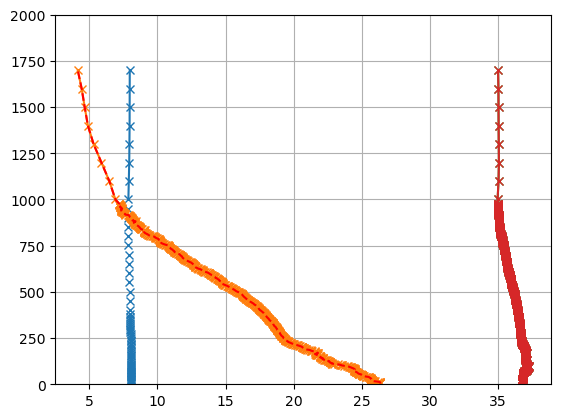

In [88]:
import matplotlib.pyplot as plt
l = 2
plt.plot(argo_n['PH_IN_SITU_TOTAL_ADJUSTED'][2,:].values, argo_n['PRES_ADJUSTED'][p,:], 'x-')
plt.plot(argo_n['TEMP_ADJUSTED'][p,:].values, argo_n['PRES_ADJUSTED'][p,:], 'x-')
plt.plot(temp_interp_p, argo_n['PRES_ADJUSTED'][p,:], 'r--')


plt.plot(argo_n['PSAL_ADJUSTED'][p,:].values, argo_n['PRES_ADJUSTED'][p,:], 'x-')
plt.plot(sal_interp_p, argo_n['PRES_ADJUSTED'][p,:], 'x-')

plt.ylim([0, 2000])
plt.grid('on')
# print(argo_n['TEMP_ADJUSTED'][2,l])
# print(argo_n['PSAL_ADJUSTED'][2,l])
# print(argo_n['PRES_ADJUSTED'][2,l])


/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_76497/2046806441.py:6: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_76497/2046806441.py:9: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


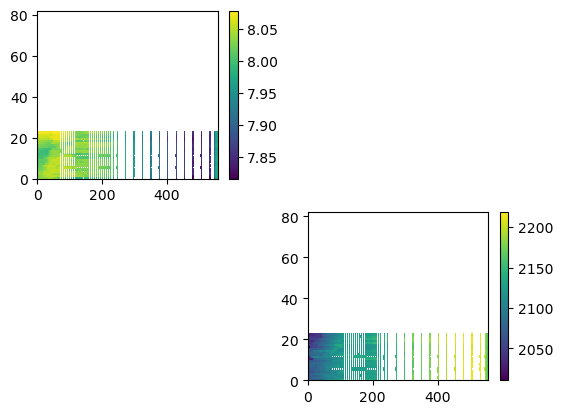

In [84]:
x_lims = [400, 470]

plt.subplot(2,2,1)
plt.pcolor(argo_n['PH_IN_SITU_TOTAL_ADJUSTED'])

plt.colorbar()
plt.subplot(2,2,4)
plt.pcolor(argo_n['DIC'])
plt.colorbar()


In [13]:
results = pyco2.sys(
        par1=argo_n.TALK_LIAR, 
        par2= argo_n.PH_IN_SITU_TOTAL_ADJUSTED,
        par1_type=1,
        par2_type=3,
        temperature=argo_n.TEMP_ADJUSTED, 
        pressure=argo_n.PRES_ADJUSTED, 
        salinity=argo_n.PSAL_ADJUSTED, 
        temperature_out=25., #fixed 25C temperature
        pressure_out=argo_n.PRES_ADJUSTED,
        opt_pH_scale = 1, #total
        opt_k_carbonic=10, #Lueker et al. 2000
        opt_k_bisulfate=1, # Dickson 1990 (Note, matlab co2sys combines KSO4 with TB. option 3 = KSO4 of Dickson & TB of Lee 2010)
        opt_total_borate=2, # Lee et al. 2010
        opt_k_fluoride=2, # Perez and Fraga 1987
        opt_buffers_mode=1, # used to be "buffers_mode='auto'" but seems to have changed in versions of pyco2?
    )

In [19]:
results.keys()
results['pH_total_out']

array([[       nan,        nan,        nan, ..., 7.67062692,        nan,
               nan],
       [       nan,        nan,        nan, ..., 7.66355797, 7.66471263,
               nan],
       [       nan,        nan,        nan, ..., 7.66693206, 7.66734867,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])